In [1]:
from symred.utils import contextualQ
#from openfermion.con import is_contextual
from symred.symplectic import PauliwordOp, random_PauliwordOp, random_symplectic_matrix
import numpy as np
import pandas as pd
import time

def runtime(func, obj, n_samples=10):
    samples = []
    for sample in range(n_samples):
        start = time.time()
        func(obj)
        stop = time.time()
        samples.append(stop - start)
    return sum(samples)/n_samples

In [211]:
P = random_PauliwordOp(5,1)
P.coeff_vec = [1]
Q = random_PauliwordOp(5,1)
Q.coeff_vec = [1]
print(P,'*', Q)
print(P*Q)
num_sign_flips = np.sum(np.bitwise_and(P.X_block, Q.Z_block),
                               axis=1)
sign_change = ((-1) ** num_sign_flips)[0]
power = np.einsum('ij->i', np.bitwise_and(P.X_block, Q.Z_block) + np.bitwise_and(P.Z_block, Q.X_block))
#print(sign_change)
print((-1j)**np.einsum('ij->i', np.bitwise_and(P.Z_block, Q.X_block)))
print((1j)**np.einsum('ij->i', np.bitwise_and(P.X_block, Q.Z_block)))
#print(P.X_block + Q.X_block*(-1)**P.Z_block)

(-1j)**power

1.000 XIYZZ * 1.000 IZZXZ
-1.000+0.000j XZXYI
[-0.-1.j]
[0.+1.j]


array([-1.+0.j])

In [162]:
def is_noncontextual(self):
    adjacency_matrix = self.commutes_termwise(self)
    # mask the terms that do not commute universally amongst the operator
    mask_non_universal = np.where(~np.all(adjacency_matrix, axis=1))[0]
    # look only at the unique rows in the masked adjacency matrix -
    # identical rows correspond with operators of the same clique
    unique_commutation_character = np.unique(
        adjacency_matrix[mask_non_universal,:][:,mask_non_universal],
        axis=0
    )
    # if the unique commutation characteristics are disjoint, i.e. no overlapping ones 
    # between rows, the operator is noncontextual - hence we sum over rows and check
    # the resulting vector consists of all ones.
    return np.all(np.count_nonzero(unique_commutation_character, axis=0)==1)

def find_noncontextual(operator):
    # order the operator terms by coefficient magnitude
    check_ops = operator.sort(key='magnitude')
    # initialise as identity with 0 coefficient
    I_symp = np.zeros(2*operator.n_qubits, dtype=int)
    noncontextual_operator = PauliwordOp(I_symp, [0])
    for i in range(check_ops.n_terms):
        if (noncontextual_operator+check_ops[i]).is_noncontextual:
            noncontextual_operator+=check_ops[i]
    return noncontextual_operator

In [160]:
n_qubits = 50
n_terms = 100
noncon = random_PauliwordOp(n_qubits,n_terms, diagonal=True) + random_PauliwordOp(n_qubits,1)
noncon_dict = noncon.to_dictionary

In [124]:
contextualQ(list(noncon_dict))

False

In [125]:
noncon.is_noncontextual

True

In [126]:
%%timeit
contextualQ(list(noncon_dict))

231 ms ± 5.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [127]:
%%timeit
is_noncontextual(noncon)

704 µs ± 30.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [266]:
n_qubits = 10

X = []
Y_symp_noncon = []
Y_legacy_noncon = []
Y_symp_random = []
Y_legacy_random = []

for n_terms in range(100):
    print(n_terms)
    X.append(n_terms+1)
    random = random_PauliwordOp(n_qubits,n_terms+1)
    random_list = list(random.to_dictionary.keys())
    noncon = random_PauliwordOp(n_qubits,n_terms, diagonal=True) + random_PauliwordOp(n_qubits,1)
    noncon_list = list(noncon.to_dictionary.keys())
    # contextual operator check
    Y_symp_random.append(runtime(is_noncontextual, random))
    Y_legacy_random.append(runtime(contextualQ, random_list))
    # noncontextual operator check
    Y_symp_noncon.append(runtime(is_noncontextual, noncon))
    Y_legacy_noncon.append(runtime(contextualQ, noncon_list))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


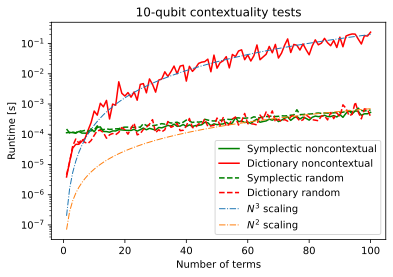

In [276]:
from matplotlib import pyplot as plt

X = np.array(X)

fig, axis = plt.subplots()
# data curves
axis.plot(X, Y_symp_noncon, color='green', label='Symplectic noncontextual')
axis.plot(X, Y_legacy_noncon, color='red', label='Dictionary noncontextual')
axis.plot(X, Y_symp_random, color='green', ls='--', label='Symplectic random')
axis.plot(X, Y_legacy_random, color='red', ls='--', label='Dictionary random')
# scaling curves
axis.plot(X, 2e-7*np.power(X, 3), label='$N^3$ scaling', ls='-.', lw=1)
axis.plot(X, 7e-8*np.power(X, 2), label='$N^2$ scaling', ls='-.', lw=1)

axis.set_yscale('log')
axis.set_ylabel('Runtime [s]')
axis.set_xlabel('Number of terms')
axis.set_title(f'{n_qubits}-qubit contextuality tests')

axis.legend()
plt.show()

In [187]:
#from openfermion.contextuality import is_contextual